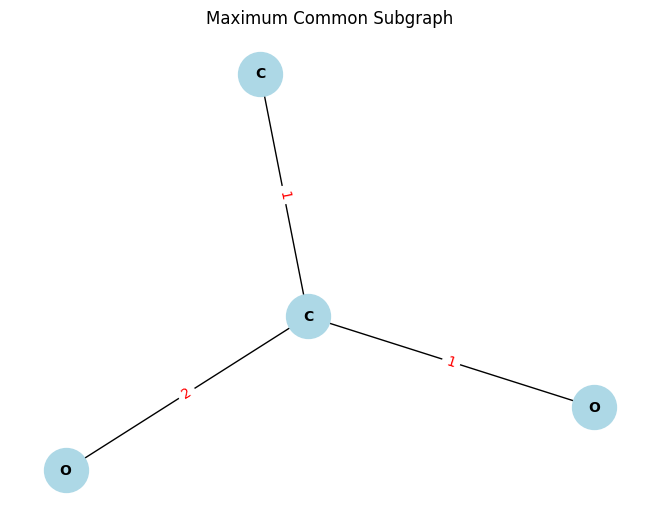

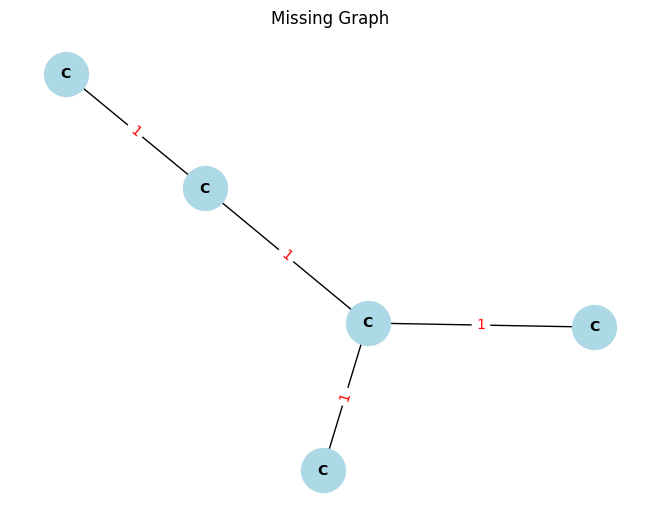

In [2]:
import networkx as nx
from pysmiles import read_smiles
import matplotlib.pyplot as plt

class ChemicalGraph:
    @staticmethod
    def smiles_to_graph(smiles):
        # Convert a SMILES string to a NetworkX graph
        return read_smiles(smiles, explicit_hydrogen=False)

    @staticmethod
    def display(graph, title='Graph'):
        # Display the given graph using networkx and matplotlib
        pos = nx.spring_layout(graph)
        node_labels = {node: data.get('element', node) for node, data in graph.nodes(data=True)}
        nx.draw(graph, pos, with_labels=True, labels=node_labels, node_size=1000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold')
        edge_labels = {(u, v): data.get('order', '') for u, v, data in graph.edges(data=True)}
        nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='red')
        plt.title(title)
        plt.show()

    @staticmethod
    def find_mcs(ref_graph, hit_graph, ignore_atom_type=False, ignore_bond_type=False):
        # Find the Maximum Common Subgraph (MCS) between two graphs
        node_match_func = lambda a, b: ((a['element'] == b['element']) and (a['charge'] == b['charge']) and (a['aromatic'] == b['aromatic'])) or ignore_atom_type
        edge_match_func = lambda a, b: (a['order'] == b['order']) or ignore_bond_type
        GM = nx.algorithms.isomorphism.GraphMatcher(ref_graph, hit_graph, node_match=node_match_func, edge_match=edge_match_func)
        try:
            mcs = max(GM.subgraph_isomorphisms_iter(), key=len)
            return ref_graph.subgraph(mcs)
        except ValueError:
            return None

    @staticmethod
    def subtract_graphs(main_graph, sub_graph):
        # Subtract sub_graph from main_graph
        unique_graph = main_graph.copy()
        for node in sub_graph.nodes():
            if node in unique_graph:
                unique_graph.remove_node(node)
        return unique_graph
    
    

# Example usage
reactant_graph = ChemicalGraph.smiles_to_graph('CC(CC)COC(=O)C')
product_graph = ChemicalGraph.smiles_to_graph('CC(=O)O')

mcs_graph = ChemicalGraph.find_mcs(reactant_graph, product_graph)

if mcs_graph:
    ChemicalGraph.display(nx.Graph(mcs_graph), 'Maximum Common Subgraph')
else:
    print("No Maximum Common Subgraph found.")

if len(reactant_graph.nodes) >= len(mcs_graph.nodes):
    missing_graph = ChemicalGraph.subtract_graphs(reactant_graph, mcs_graph)
else:
    missing_graph = ChemicalGraph.subtract_graphs(product_graph, mcs_graph)

if missing_graph:
    ChemicalGraph.display(nx.Graph(missing_graph), 'Missing Graph')
else:
    print("No missing part found.")


In [6]:
from rdkit import Chem
from rdkit.Chem import rdmolops

def graph_to_molecule(graph):
    mol = Chem.RWMol()

    # Map for bond types
    bond_type_map = {
        1: Chem.rdchem.BondType.SINGLE,
        2: Chem.rdchem.BondType.DOUBLE,
        3: Chem.rdchem.BondType.TRIPLE,
        'aromatic': Chem.rdchem.BondType.AROMATIC
        # Add other bond types if necessary
    }

    # Add atoms to the molecule
    node_to_idx = {}
    for node, data in graph.nodes(data=True):
        atom = Chem.Atom(data['element'])
        mol_idx = mol.AddAtom(atom)
        node_to_idx[node] = mol_idx

    # Add bonds to the molecule
    for u, v, data in graph.edges(data=True):
        bond_type = data.get('order')
        rdkit_bond_type = bond_type_map.get(bond_type)
        if rdkit_bond_type:
            mol.AddBond(node_to_idx[u], node_to_idx[v], rdkit_bond_type)

    # Sanitize the molecule (important for proper chemical structure)
    rdmolops.SanitizeMol(mol)

    display(mol)
    # Convert to SMILES (or another format as needed)
    smiles = Chem.MolToSmiles(mol)
    return smiles

# Example usage
# Ensure your graph has 'element' attributes for nodes and 'order' for edges
# smiles = graph_to_molecule(your_networkx_graph)


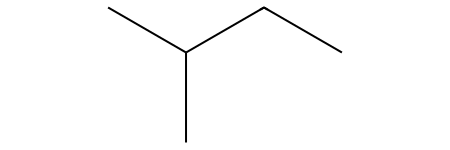

'CCC(C)C'

In [7]:
graph_to_molecule(missing_graph)

In [22]:
import sys
sys.path.append('../SynRBL')
from SynRBL.rsmi_utils import load_database


In [18]:
root_dir = Path(_dh[-1])
root_dir

PosixPath('/Users/tieulongphan/Documents/Task/TACsy/SynRBL/Notebook')

In [ ]:
from SynRBL.rsmi_utils import load_database
diff = load_database('test.json')

In [9]:
def remove_duplicate_diff_formulas(data):
    seen_formulas = set()
    unique_data = []

    for entry in data:
        formula_key = frozenset(entry['Diff_formula'].items())
        if formula_key not in seen_formulas:
            seen_formulas.add(formula_key)
            unique_data.append(entry)

    return unique_data

def sort_by_diff_formula_length(data):
    return sorted(data, key=lambda x: len(x['Diff_formula']))

# Remove duplicates
unique_data = remove_duplicate_diff_formulas(diff)

# Sort by length of 'Diff_formula'
sorted_data = sort_by_diff_formula_length(unique_data)


NameError: name 'diff' is not defined

In [5]:
sorted_data[41:50]

NameError: name 'sorted_data' is not defined

In [10]:
from rdkit.Chem import AllChem, rdChemReactions
smi = sorted_data[46:47][0]['new_reaction']
rxn = rdChemReactions.ReactionFromSmarts(smi, useSmiles= True)

rxn

NameError: name 'sorted_data' is not defined

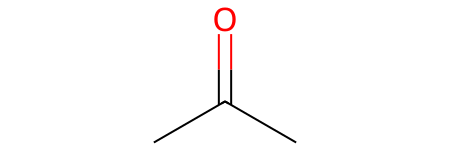

In [195]:
Chem.MolFromSmiles('CC(=O)C')

In [196]:
sorted_data[30:31][0]

{'Diff_formula': {'I': 1, 'Cu': 1, 'Q': 0},
 'new_reaction': 'COc1ccc(-c2cnc3c(n2)c(I)cn3S(=O)(=O)c2ccc(C)cc2)cc1OC.N#C[Cu]>>COc1ccc(-c2cnc3c(n2)c(C#N)cn3S(=O)(=O)c2ccc(C)cc2)cc1OC.[Cu+].[I-]'}

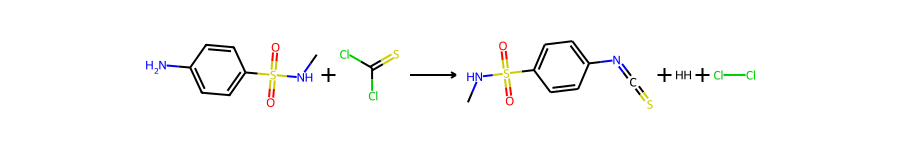

In [197]:
from rdkit.Chem import AllChem, rdChemReactions
smi = 'CNS(=O)(=O)c1ccc(N)cc1.S=C(Cl)Cl>>CNS(=O)(=O)c1ccc(N=C=S)cc1.[HH].ClCl'
rxn = rdChemReactions.ReactionFromSmarts(smi, useSmiles= True)

rxn

In [198]:
H:2; Cl:2

In [199]:
{'Q':1, 'H':1}
{'Q':0, 'H':2}

{'Q': 0, 'H': 2}

# Fix

In [1]:
from SynRBL.rsmi_utils import calculate_net_charge, find_shortest_sublists
from SynRBL.SynRuleImpute import SyntheticRuleMatcher

In [2]:
rules = [
    {"formula": "H2", "smiles": "[HH]", "Composition": {"Q": 0, "H": 2}},
    {"formula": "F2", "smiles": "FF", "Composition": {"Q": 0, "F": 2}},
    {"formula": "Cl2", "smiles": "ClCl", "Composition": {"Q": 0, "Cl": 2}},
    {"formula": "Br2", "smiles": "BrBr", "Composition": {"Q": 0, "Br": 2}},
    {"formula": "I2", "smiles": "II", "Composition": {"Q": 0, "I": 2}},
    {"formula": "H+", "smiles": "[H+]", "Composition": {"Q": 1, "H": 1}},
    {"formula": "Na+", "smiles": "[Na+]", "Composition": {"Q": 1, "Na": 1}},
    {"formula": "Li+", "smiles": "[Li+]", "Composition": {"Q": 1, "Li": 1}},
    {"formula": "K+", "smiles": "[K+]", "Composition": {"Q": 1, "K": 1}},
    {"formula": "Ca2+", "smiles": "[Ca+2]", "Composition": {"Q": 2, "Ca": 1}},
    {"formula": "Mg2+", "smiles": "[Mg+2]", "Composition": {"Q": 2, "Mg": 1}},
    {"formula": "Ba2+", "smiles": "[Ba+2]", "Composition": {"Q": 2, "Ba": 1}},
    {"formula": "Al3+", "smiles": "[Al+3]", "Composition": {"Q": 3, "Al": 1}},
    {"formula": "Zn2+", "smiles": "[Zn+2]", "Composition": {"Q": 2, "Zn": 1}},
    {"formula": "Cu2+", "smiles": "[Cu+2]", "Composition": {"Q": 2, "Cu": 1}},
    {"formula": "Cu+", "smiles": "[Cu+]", "Composition": {"Q": 1, "Cu": 1}},
    {"formula": "F-", "smiles": "[F-]", "Composition": {"Q": -1, "F": 1}},
    {"formula": "Cl-", "smiles": "[Cl-]", "Composition": {"Q": -1, "Cl": 1}},
    {"formula": "Br-", "smiles": "[Br-]", "Composition": {"Q": -1, "Br": 1}},
    {"formula": "I-", "smiles": "[I-]", "Composition": {"Q": -1, "I": 1}},
    {"formula": "N2", "smiles": "N#N", "Composition": {"Q": 0, "N": 2}},
    {"formula": "O2", "smiles": "O=O", "Composition": {"Q": 0, "O": 2}},
    {"formula": "S^2-", "smiles": "[S^2-]", "Composition": {"Q": -2, "S": 1}},
    {"formula": "H2S", "smiles": "H2S", "Composition": {"Q": 0, "H":2, "S": 1}},
    {"formula": "HS-", "smiles": "[H][S-]", "Composition": {"Q": -1, "H":1, "S": 1}},
    {"formula": "OH-", "smiles": "[OH-]", "Composition": {"Q": -1, "H": 1, "O": 1}},
    {"formula": "NH3", "smiles": "N", "Composition": {"Q": 0, "H": 3, "N": 1}},
    {"formula": "NO2-", "smiles": "O=N[O-]", "Composition": {"Q": -1, "O": 2, "N": 1}},
    {"formula": "NO3-", "smiles": "[N+](=O)([O-])[O-]", "Composition": {"Q": -1, "O": 3, "N": 1}},
    {"formula": "NH2-", "smiles": "[NH2-]", "Composition": {"Q": -1, "H": 2, "N": 1}},
    {"formula": "CH4", "smiles": "C", "Composition": {"Q": 0, "H": 4, "C": 1}},
    {"formula": "C2H6", "smiles": "CC", "Composition": {"Q": 0, "H": 6, "C": 2}},
    {"formula": "C2H4", "smiles": "C=C", "Composition": {"Q": 0, "H": 4, "C": 2}},
    {"formula": "C2H2", "smiles": "C#C", "Composition": {"Q": 0, "H": 2, "C": 2}},
    {"formula": "C2H-", "smiles": "[C-]#C", "Composition": {"Q": -1, "H": 1, "C": 2}},
    {"formula": "C3H8", "smiles": "CCC", "Composition": {"Q": 0, "H": 8, "C": 3}},
    {"formula": "nC3H6", "smiles": "C=CC", "Composition": {"Q": 0, "H": 6, "C": 3}},
    {"formula": "cC3H6", "smiles": "C1CC1", "Composition": {"Q": 0, "H": 6, "C": 3}},
    {"formula": "nC4H10", "smiles": "C=CCC", "Composition": {"Q": 0, "C": 4, "H": 8}},
    {"formula": "nC4H8", "smiles": "C=C(C)C", "Composition": {"Q": 0, "C": 4, "H": 8}},
    {"formula": "iC4H10", "smiles": "CCCC", "Composition": {"Q": 0, "C": 4, "H": 10}},
    {"formula": "iC4H10", "smiles": "CC(C)C", "Composition": {"Q": 0, "C": 4, "H": 10}},
    {"formula": "C3H4", "smiles": "C#CC", "Composition": {"Q": 0, "H": 4, "C": 3}},
    {"formula": "C6H6", "smiles": "c1ccccc1", "Composition": {"Q": 0, "C": 6, "H": 6}},
    {"formula": "C7H8", "smiles": "Cc1ccccc1", "Composition": {"Q": 0, "C": 7, "H": 8}},
    {"formula": "CO2", "smiles": "O=C=O", "Composition": {"Q": 0, "C": 1, "O": 2}},
    {"formula": "[CO3]2-", "smiles": "O=C([O-])[O-]", "Composition": {"Q": -2, "C": 1, "O": 3}},
    {"formula": "SO4^2-", "smiles": "[SO4^2-]", "Composition": {"Q": -2, "S": 1, "O": 4}},
    {"formula": "NO3-", "smiles": "[NO3-]", "Composition": {"Q": -1, "N": 1, "O": 3}},
    {"formula": "PO4^3-", "smiles": "[PO4^3-]", "Composition": {"Q": -3, "P": 1, "O": 4}},
     {"formula": "CH3OH", "smiles": "CO", "Composition": {"Q": 0, "C": 1, "H": 4, "O": 1}},
    {"formula": "C2H5OH", "smiles": "CCO", "Composition": {"Q": 0, "C": 2, "H": 6, "O": 1}},
    {"formula": "CH3COO-", "smiles": "[CH3COO-]", "Composition": {"Q": -1, "C": 2, "H": 3, "O": 2}},
    {"formula": "CH3COCH3", "smiles": "CC(=O)C", "Composition": {"Q": 0, "C": 3, "H": 6, "O": 1}},
    {"formula": "CH2O", "smiles": "C=O", "Composition": {"Q": 0, "C": 1, "H": 2, "O": 1}},
    {"formula": "CH3CHO", "smiles": "CC=O", "Composition": {"Q": 0, "C": 2, "H": 4, "O": 1}},
    {"formula": "C2H6O2", "smiles": "C(CO)O", "Composition": {"Q": 0, "C": 2, "H": 6, "O": 2}},
    {"formula": "C6H5OH", "smiles": "c1ccccc1O", "Composition": {"Q": 0, "C": 6, "H": 6, "O": 1}},
    
]


In [3]:
data_dict = {'H': 2, 'Cl': 2,}
matcher = SyntheticRuleMatcher(rules, data_dict, select='all', ranking='ion_priority')
best_solution = matcher.match()
print(best_solution)
# Output: [{'smiles': 'C1=CC=CC=C1', 'Ratio': 1}]

[[{'smiles': '[H+]', 'Ratio': 2}, {'smiles': '[Cl-]', 'Ratio': 2}]]
